In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import xarray as xr

# Download points

In [2]:
byrd_bedmap_points = pd.read_csv('/home/kim/ice_thickness/data/byrd_200km.csv')

In [3]:
byrd_bedmap_points["t"].describe()

count    465760.000000
mean       1583.798401
std         567.502192
min           0.000000
25%        1235.620000
50%        1627.690000
75%        1960.980000
max        3620.100000
Name: t, dtype: float64

In [4]:
byrd_bedmap_points["source"].value_counts()

NASA_2011_ICEBRIDGE_AIR_BM2.csv    315520
UTIG_2010_ICECAP_AIR_BM3.csv        97702
NASA_2017_ICEBRIDGE_AIR_BM3.csv     27877
NASA_2013_ICEBRIDGE_AIR_BM3.csv     15628
BAS_2007_AGAP_AIR_BM2.csv            8208
LDEO_2015_ROSETTA_AIR_BM3.csv         631
BEDMAP1_1966-2000_AIR_BM1.csv         193
UTIG_2004_AGASEA_AIR_BM2.csv            1
Name: source, dtype: int64

# Download map

In [5]:
path_to_file_server = 'data/byrd_bedmachine.nc'
byrd_bedmachine = xr.open_dataset(path_to_file_server)

In [43]:
byrd_bedmachine

<xarray.Dataset>
Dimensions:                   (x: 400, y: 400)
Coordinates:
  * x                         (x) int32 350000 350500 351000 ... 549000 549500
  * y                         (y) int32 -800500 -801000 ... -999500 -1000000
Data variables: (12/16)
    mapping                   |S1 ...
    mask                      (y, x) int8 ...
    firn                      (y, x) float32 ...
    surface                   (y, x) float32 ...
    thickness                 (y, x) float32 ...
    bed                       (y, x) float32 ...
    ...                        ...
    bed_land                  (y, x) float32 ...
    bed_ellipsoid             (y, x) float32 1.834e+03 1.818e+03 ... 624.9 644.2
    surface_ellipsoid         (y, x) float32 2.113e+03 2.108e+03 ... 2.078e+03
    surface_ellipsoid_true    (y, x) float32 2.136e+03 2.131e+03 ... 2.1e+03
    thickness_ellipsoid       (y, x) float32 236.4 246.7 ... 1.398e+03 1.383e+03
    thickness_ellipsoid_true  (y, x) float32 259.8 270.2 ... 1.42e+03 1.406e+03
Attributes: (12/17)
    Conventions:                 CF-1.7
    Title:                       BedMachine Antarctica
    Author:                      Mathieu Morlighem
    version:                     03-Jun-2022 (v3.4)
    nx:                          13333.0
    ny:                          13333.0
    ...                          ...
    ymax:                        3333000
    spacing:                     500
    no_data:                     -9999.0
    license:                     No restrictions on access or use
    Data_citation:               Morlighem M. et al., (2019), Deep glacial tr...
    Notes:                       Data processed at the Department of Earth Sy...

# Corrections

Bed, thickness, and surface elevation need to be corrected to ellipsoid.   
Ice thickness also needs to be firn corrected.

In [6]:
byrd_bedmachine["bed_ellipsoid"] = byrd_bedmachine["bed"] + byrd_bedmachine["geoid"]

byrd_bedmachine["surface_ellipsoid"] = byrd_bedmachine["surface"] + byrd_bedmachine["geoid"]
byrd_bedmachine["surface_ellipsoid_true"] = byrd_bedmachine["surface_ellipsoid"] + byrd_bedmachine["firn"]

byrd_bedmachine["thickness_ellipsoid"] = byrd_bedmachine["thickness"] + byrd_bedmachine["geoid"]
byrd_bedmachine["thickness_ellipsoid_true"] = byrd_bedmachine["thickness_ellipsoid"] + byrd_bedmachine["firn"]

## Define bed topography color map from Bedmachine

In [7]:
cvals  = [-2000, -1500, -1000, -500, -1,
           0, 
          1, 250, 500, 750, 1000]

colors = ["#001079", "#0023c1", "#006cef", "#47bdfc", "#bee6fa", 
          "#7eb3a1",
          "#2D6E2A", "#DFFBBC", "#AFAD48", "#7D5F18", "#481B02"]

# Create a colormap object
norm = plt.Normalize(np.min(cvals), np.max(cvals))
tuples = list(zip(map(norm, cvals), colors))

bedmachine_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)

## Define ice thickness color map from Bedmachine

In [8]:
cvals  = [0, 
          1, 250, 500, 750, 1000]

colors = ["#7eb3a1",
          "#bee6fa", "#47bdfc", "#006cef", "#0023c1", "#001079"]

# Create a colormap object
norm = plt.Normalize(np.min(cvals), np.max(cvals))
tuples = list(zip(map(norm, cvals), colors))

icethickness_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)

## Visualise bed topography from BedMachine

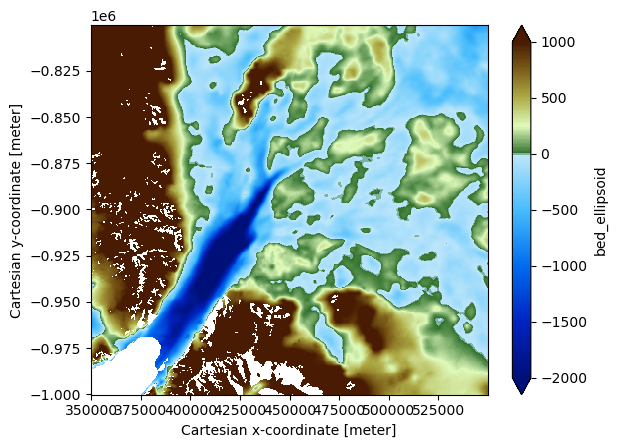

In [9]:
byrd_bedmachine.bed_ellipsoid.plot(cmap = bedmachine_cmap, vmin = -2000, vmax = 1000)

## Visualise surface from BedMachine

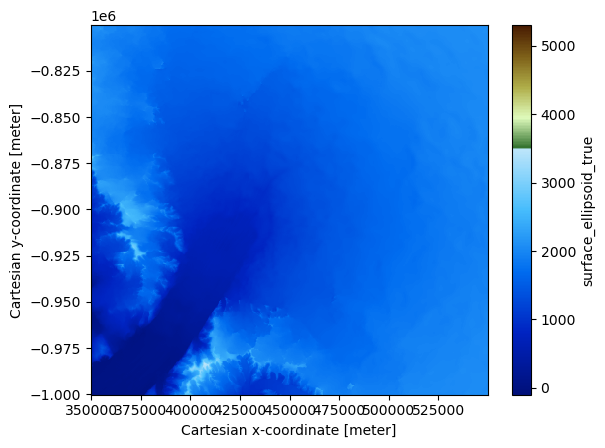

In [10]:
byrd_bedmachine.surface_ellipsoid_true.plot(cmap = bedmachine_cmap, vmin = -100, vmax = 5300)

## Visualise thickness from BedMachine

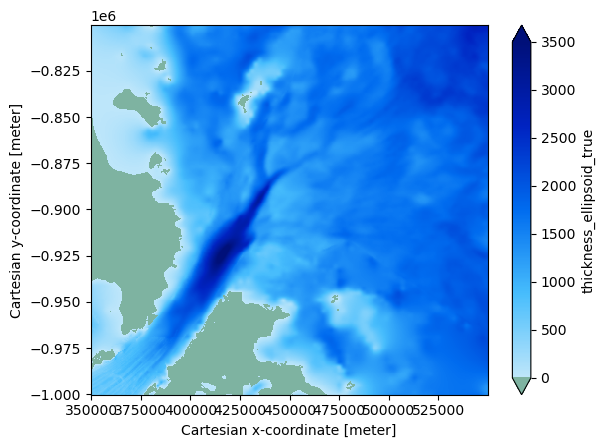

In [11]:
byrd_bedmachine.thickness_ellipsoid_true.plot(cmap = icethickness_cmap, vmin = 0, vmax = 3500)

# Visualise overlay of map and point data

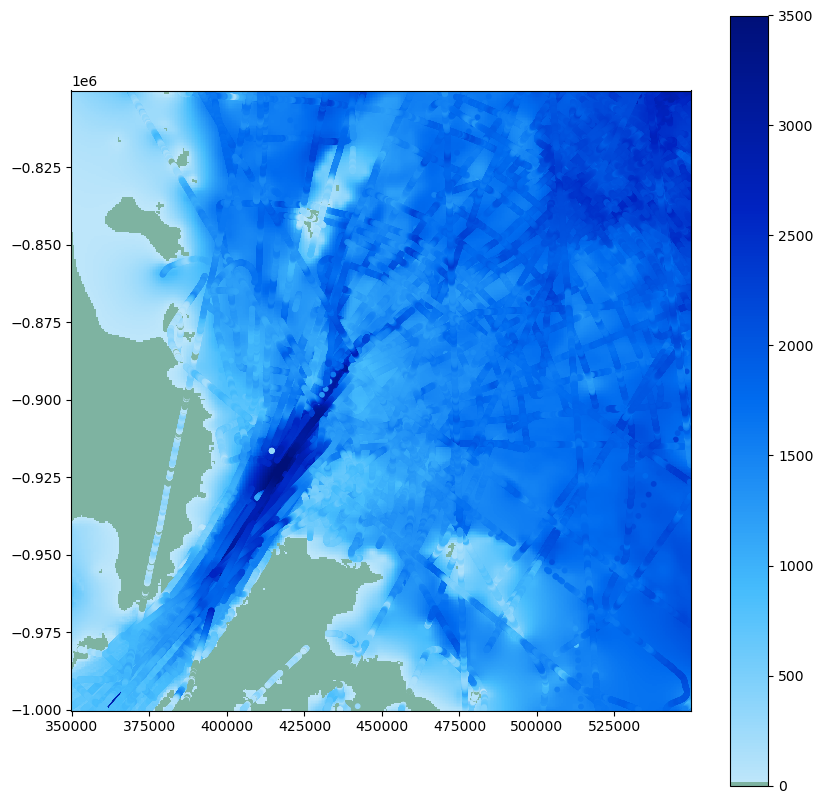

In [12]:
XX, YY = np.meshgrid(byrd_bedmachine.x, byrd_bedmachine.y)

fig, ax = plt.subplots(figsize = (10, 10))

# Plot bed topography mesh
ax.pcolormesh(XX, YY, byrd_bedmachine.thickness_ellipsoid_true, cmap = icethickness_cmap, vmin = 0, vmax = 3500)

# Plot data points
ax.scatter(byrd_bedmap_points["x"], byrd_bedmap_points["y"], 
           c = byrd_bedmap_points["t"], 
           s = 10,
           cmap = icethickness_cmap, vmin = 0, vmax = 3500)

fig.colorbar(mappable = ax.collections[0], ax = ax)
ax.set_aspect('equal')

# Use Plotly's Zoom to find datapoints we need to cull

In [1]:
import plotly.express as px
fig = px.scatter(
    x = byrd_bedmap_points["x"], 
    y = byrd_bedmap_points["y"], 
    color = byrd_bedmap_points["t"],
    color_continuous_scale = px.colors.sequential.ice_r)

# Fix aspect ratio
fig.update_layout(
    width = 800,
    height = 800)

fig.show()

NameError: name 'residual' is not defined

5 measurements from NASA_2011_ICEBRIDGE_AIR_BM2.csv are ~300 m ice thickness while neighbouring ones are ~2500 m. These truely seems like measurement errors. The other measurements are just next to it so we are confident in removing them. 

IDs: 268494 - 268498

In [14]:
byrd_bedmap_points[(byrd_bedmap_points.x > 414400) & (byrd_bedmap_points.x < 414600) & 
                   (byrd_bedmap_points.y > -916600) & (byrd_bedmap_points.y < -916400)]

,Unnamed: 0,lon,lat,x,y,s,t,b,b_inferred,source
268494,268494,155.669486,-80.761635,414415.387033,-916526.583712,670.19,283.95,386.23,False,NASA_2011_ICEBRIDGE_AIR_BM2.csv
268495,268495,155.668304,-80.761826,414425.690667,-916499.006473,670.86,290.72,380.14,False,NASA_2011_ICEBRIDGE_AIR_BM2.csv
268496,268496,155.667124,-80.762016,414436.006401,-916471.543291,671.53,297.49,374.04,False,NASA_2011_ICEBRIDGE_AIR_BM2.csv
268497,268497,155.665940,-80.762206,414446.385162,-916444.051144,672.21,304.26,367.95,False,NASA_2011_ICEBRIDGE_AIR_BM2.csv
268498,268498,155.664756,-80.762396,414456.762965,-916416.558964,672.87,311.03,361.84,False,NASA_2011_ICEBRIDGE_AIR_BM2.csv


The following curved flight line from NASA_2011_ICEBRIDGE_AIR_BM2.csv also could be a measurement error.

IDs: 20004 - 20090

In [15]:
byrd_bedmap_points[(byrd_bedmap_points.x > 409500) & (byrd_bedmap_points.x < 411850) & 
                   (byrd_bedmap_points.y > -931700) & (byrd_bedmap_points.y < -930000)]

,Unnamed: 0,lon,lat,x,y,s,t,b,b_inferred,source
20004,20004,156.119142,-80.656957,411843.407104,-930216.373388,642.63,2349.68,-1707.05,False,NASA_2011_ICEBRIDGE_AIR_BM2.csv
20005,20005,156.120796,-80.656956,411816.597948,-930228.361980,641.67,2328.47,-1686.80,False,NASA_2011_ICEBRIDGE_AIR_BM2.csv
20006,20006,156.122457,-80.656956,411789.630530,-930240.300119,640.73,2314.60,-1673.88,False,NASA_2011_ICEBRIDGE_AIR_BM2.csv
20007,20007,156.124114,-80.656954,411762.816229,-930252.408712,639.81,2300.74,-1660.93,False,NASA_2011_ICEBRIDGE_AIR_BM2.csv
20008,20008,156.125766,-80.656952,411736.082754,-930264.480601,638.92,2286.88,-1647.96,False,NASA_2011_ICEBRIDGE_AIR_BM2.csv
...,...,...,...,...,...,...,...,...,...,...
20086,20086,156.251204,-80.653132,409866.688547,-931546.008104,622.80,1179.96,-557.16,False,NASA_2011_ICEBRIDGE_AIR_BM2.csv
20087,20087,156.252683,-80.653012,409847.926269,-931568.598745,621.99,1168.50,-546.51,False,NASA_2011_ICEBRIDGE_AIR_BM2.csv
20088,20088,156.254153,-80.652889,409829.441532,-931591.424940,622.04,1157.52,-535.48,False,NASA_2011_ICEBRIDGE_AIR_BM2.csv
20089,20089,156.255617,-80.652765,409811.097483,-931614.307980,621.47,1146.17,-524.70,False,NASA_2011_ICEBRIDGE_AIR_BM2.csv


In [16]:
byrd_bedmap_points[(byrd_bedmap_points.x > 428000) & (byrd_bedmap_points.x < 438000) & 
                   (byrd_bedmap_points.y > -903000) & (byrd_bedmap_points.y < -88400) & 
                   (byrd_bedmap_points.source == "BEDMAP1_1966-2000_AIR_BM1.csv")
                   ]

,Unnamed: 0,lon,lat,x,y,s,t,b,b_inferred,source
136,136,153.7902,-80.91580,436805.373245,-887322.585003,1126.0,1627.0,-501.0,False,BEDMAP1_1966-2000_AIR_BM1.csv
137,137,153.9120,-80.90089,435634.829770,-889712.933025,1094.0,1827.0,-733.0,False,BEDMAP1_1966-2000_AIR_BM1.csv
138,138,154.0365,-80.88860,434288.681089,-891865.310439,1068.0,1586.0,-518.0,False,BEDMAP1_1966-2000_AIR_BM1.csv
139,139,154.2815,-80.86011,431822.562288,-896520.098458,1004.0,1274.0,-270.0,False,BEDMAP1_1966-2000_AIR_BM1.csv
140,140,154.3908,-80.84920,430627.046329,-898417.741396,962.0,1271.0,-309.0,False,BEDMAP1_1966-2000_AIR_BM1.csv
141,141,154.5139,-80.83560,429335.548130,-900682.960581,919.0,1182.0,-263.0,False,BEDMAP1_1966-2000_AIR_BM1.csv
142,142,154.6275,-80.82201,428185.552674,-902874.824379,866.0,1293.0,-427.0,False,BEDMAP1_1966-2000_AIR_BM1.csv
188,188,153.6711,-80.92950,437984.700072,-885070.496926,1165.0,1717.0,-552.0,False,BEDMAP1_1966-2000_AIR_BM1.csv
189,189,154.1583,-80.87500,433039.792096,-894124.534405,1034.0,1230.0,-196.0,False,BEDMAP1_1966-2000_AIR_BM1.csv


9 measurements from Bedmap1 in a deep area seem off. IDs are in two different segments.

In [17]:
removal_ids = np.concatenate((np.linspace(20004, 20090, 87), np.linspace(268494, 268498, 5), np.linspace(136, 142, 7), np.linspace(188, 189, 2)))

Note some strong outliers that we deem implausible and thus remove.

# Outlier removal from Bedmap points

## Subset to find outliers

In [18]:
byrd_bedmap_points_bedmap1 = byrd_bedmap_points[byrd_bedmap_points["source"] == "BEDMAP1_1966-2000_AIR_BM1.csv"]
byrd_bedmap_points_agasea = byrd_bedmap_points[byrd_bedmap_points["source"] == "UTIG_2004_AGASEA_AIR_BM2.csv"]
byrd_bedmap_points_rosetta = byrd_bedmap_points[byrd_bedmap_points["source"] == "LDEO_2015_ROSETTA_AIR_BM3.csv"]
byrd_bedmap_points_bas = byrd_bedmap_points[byrd_bedmap_points["source"] == "BAS_2007_AGAP_AIR_BM2.csv"]

## Inspect Bedmap1 data (old)

These are only a few data points so we rather remove them

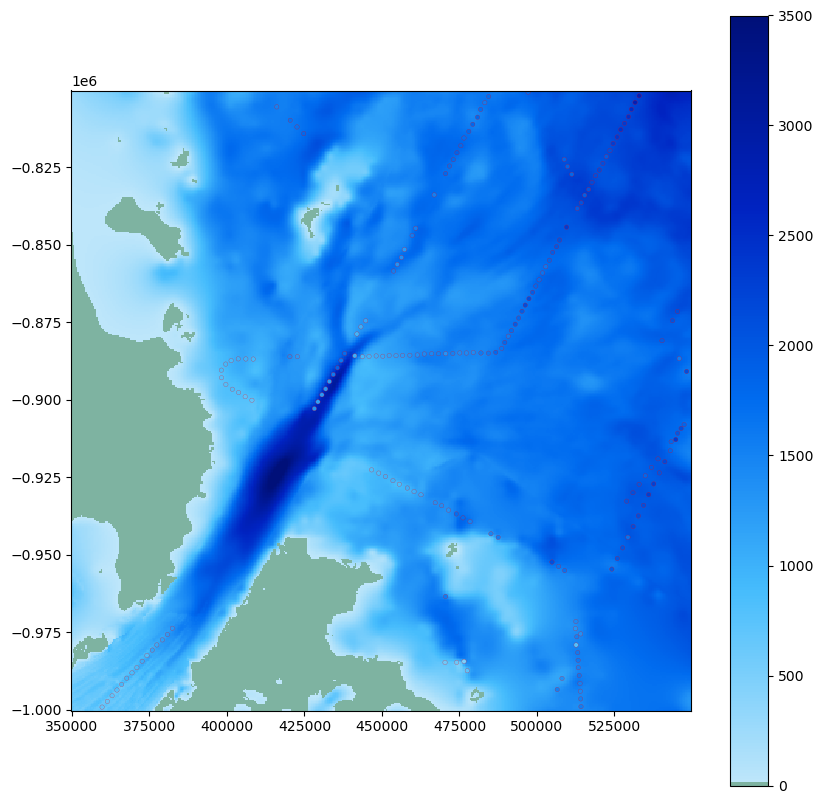

In [19]:
XX, YY = np.meshgrid(byrd_bedmachine.x, byrd_bedmachine.y)

fig, ax = plt.subplots(figsize = (10, 10))

# Plot bed topography mesh
ax.pcolormesh(XX, YY, byrd_bedmachine.thickness_ellipsoid_true, cmap = icethickness_cmap, vmin = 0, vmax = 3500)

# Plot data points
ax.scatter(byrd_bedmap_points_bedmap1["x"], byrd_bedmap_points_bedmap1["y"], 
           c = byrd_bedmap_points_bedmap1["t"], 
           s = 10,
           edgecolors = "red",
           linewidth = 0.15,
           cmap = icethickness_cmap, vmin = 0, vmax = 3500)

fig.colorbar(mappable = ax.collections[0], ax = ax)
ax.set_aspect('equal')

## Inspect UTIG Agasea data point

This single data points is in the bottom right.

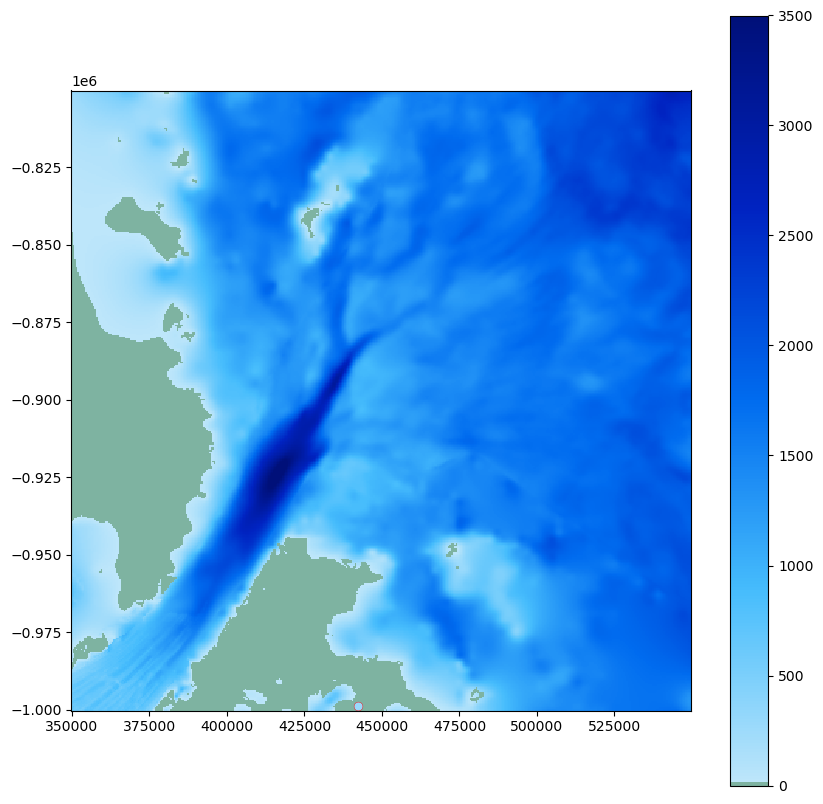

In [20]:
XX, YY = np.meshgrid(byrd_bedmachine.x, byrd_bedmachine.y)

fig, ax = plt.subplots(figsize = (10, 10))

# Plot bed topography mesh
ax.pcolormesh(XX, YY, byrd_bedmachine.thickness_ellipsoid_true, cmap = icethickness_cmap, vmin = 0, vmax = 3500)

# Plot data points
ax.scatter(byrd_bedmap_points_agasea["x"], byrd_bedmap_points_agasea["y"], 
           c = byrd_bedmap_points_agasea["t"], 
           s = 40,
           edgecolors = "red",
           linewidth = 0.3,
           cmap = icethickness_cmap, vmin = 0, vmax = 3500)

fig.colorbar(mappable = ax.collections[0], ax = ax)
ax.set_aspect('equal')

## Insect BAS data points

These points are very close together but differ vastly from other measurements.
- 2007

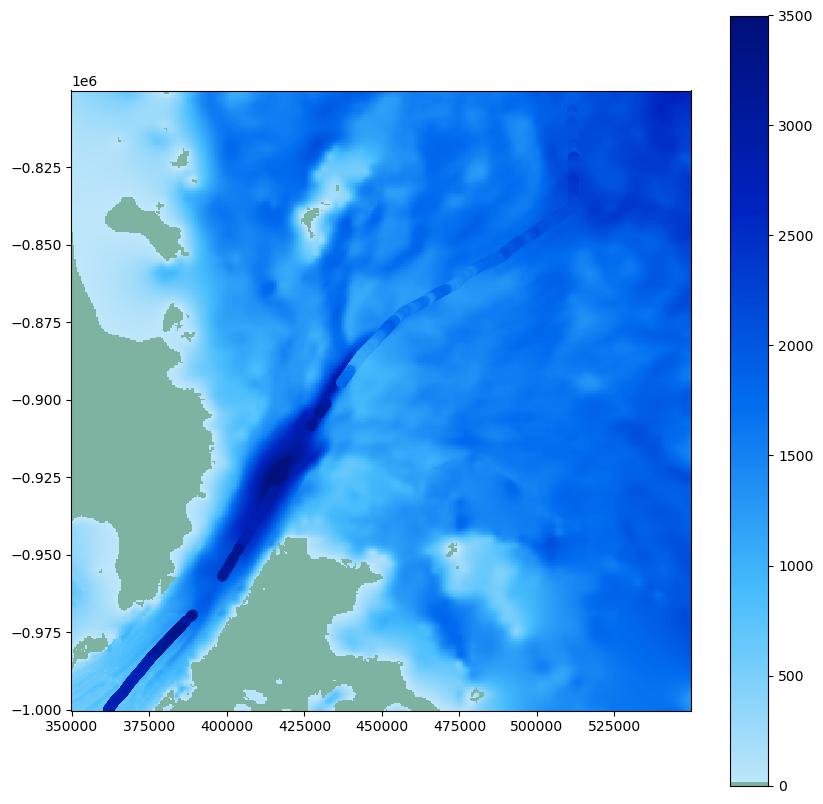

In [21]:
XX, YY = np.meshgrid(byrd_bedmachine.x, byrd_bedmachine.y)

fig, ax = plt.subplots(figsize = (10, 10))

# Plot bed topography mesh
ax.pcolormesh(XX, YY, byrd_bedmachine.thickness_ellipsoid_true, cmap = icethickness_cmap, vmin = 0, vmax = 3500)

# Plot data points
ax.scatter(byrd_bedmap_points_bas["x"], byrd_bedmap_points_bas["y"], 
           c = byrd_bedmap_points_bas["t"], 
           s = 40,
           # edgecolors = "red",
           # linewidth = 0.1,
           cmap = icethickness_cmap, vmin = 0, vmax = 3500)

fig.colorbar(mappable = ax.collections[0], ax = ax)
ax.set_aspect('equal')

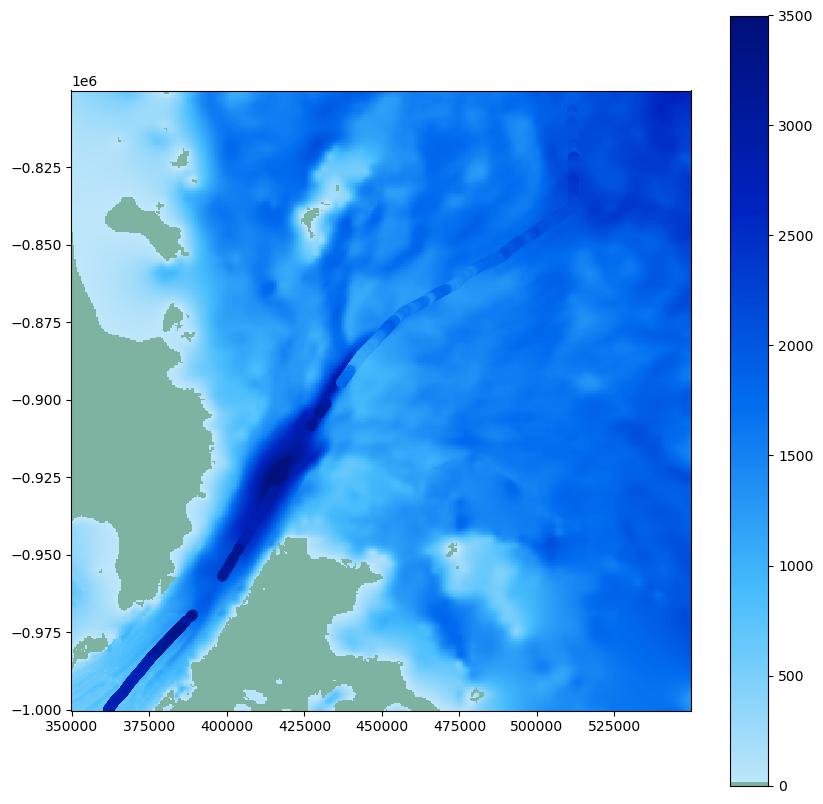

In [22]:
XX, YY = np.meshgrid(byrd_bedmachine.x, byrd_bedmachine.y)

fig, ax = plt.subplots(figsize = (10, 10))

# Plot bed topography mesh
ax.pcolormesh(XX, YY, byrd_bedmachine.thickness_ellipsoid_true, cmap = icethickness_cmap, vmin = 0, vmax = 3500)

# Plot data points
ax.scatter(byrd_bedmap_points_bas["x"], byrd_bedmap_points_bas["y"], 
           c = byrd_bedmap_points_bas["t"], 
           s = 40,
           # edgecolors = "red",
           # linewidth = 0.1,
           cmap = icethickness_cmap, vmin = 0, vmax = 3500)

fig.colorbar(mappable = ax.collections[0], ax = ax)
ax.set_aspect('equal')

# Remove

- BAS_2007_AGAP_AIR_BM2.csv
    - causes a lot of issues, mainly in the Southern part

Currently we keep
- BEDMAP1_1966-2000_AIR_BM1.csv
    - causes issues mainly in the Northern part

In [23]:
np.take(byrd_bedmap_points, indices = removal_ids, axis = 0)

,Unnamed: 0,lon,lat,x,y,s,t,b,b_inferred,source
20004,20004,156.119142,-80.656957,411843.407104,-930216.373388,642.63,2349.68,-1707.05,False,NASA_2011_ICEBRIDGE_AIR_BM2.csv
20005,20005,156.120796,-80.656956,411816.597948,-930228.361980,641.67,2328.47,-1686.80,False,NASA_2011_ICEBRIDGE_AIR_BM2.csv
20006,20006,156.122457,-80.656956,411789.630530,-930240.300119,640.73,2314.60,-1673.88,False,NASA_2011_ICEBRIDGE_AIR_BM2.csv
20007,20007,156.124114,-80.656954,411762.816229,-930252.408712,639.81,2300.74,-1660.93,False,NASA_2011_ICEBRIDGE_AIR_BM2.csv
20008,20008,156.125766,-80.656952,411736.082754,-930264.480601,638.92,2286.88,-1647.96,False,NASA_2011_ICEBRIDGE_AIR_BM2.csv
...,...,...,...,...,...,...,...,...,...,...
140,140,154.390800,-80.849200,430627.046329,-898417.741396,962.00,1271.00,-309.00,False,BEDMAP1_1966-2000_AIR_BM1.csv
141,141,154.513900,-80.835600,429335.548130,-900682.960581,919.00,1182.00,-263.00,False,BEDMAP1_1966-2000_AIR_BM1.csv
142,142,154.627500,-80.822010,428185.552674,-902874.824379,866.00,1293.00,-427.00,False,BEDMAP1_1966-2000_AIR_BM1.csv
188,188,153.671100,-80.929500,437984.700072,-885070.496926,1165.00,1717.00,-552.00,False,BEDMAP1_1966-2000_AIR_BM1.csv


In [24]:
byrd_bedmap_points_cleaned = byrd_bedmap_points[(byrd_bedmap_points["source"]!= "BAS_2007_AGAP_AIR_BM2.csv") & 
                                                (byrd_bedmap_points["Unnamed: 0"].isin(removal_ids) == False)]
byrd_bedmap_points_cleaned

,Unnamed: 0,lon,lat,x,y,s,t,b,b_inferred,source
0,0,152.985600,-79.762700,506520.230349,-993484.578865,2041.00,1520.00,521.00,False,BEDMAP1_1966-2000_AIR_BM1.csv
1,1,152.365800,-79.853700,512616.441896,-979120.903634,2002.00,791.00,1211.00,False,BEDMAP1_1966-2000_AIR_BM1.csv
2,2,152.210800,-79.876400,514104.771891,-975532.137582,1979.00,1347.00,632.00,False,BEDMAP1_1966-2000_AIR_BM1.csv
3,3,151.231000,-80.001010,524146.514676,-954642.091619,2014.00,1934.00,80.00,False,BEDMAP1_1966-2000_AIR_BM1.csv
4,4,151.063600,-80.020710,525890.208287,-951219.665584,2012.00,1962.00,50.00,False,BEDMAP1_1966-2000_AIR_BM1.csv
...,...,...,...,...,...,...,...,...,...,...
465755,465755,158.087397,-80.387113,390665.287173,-971193.080867,164.36,1540.87,-1376.51,False,UTIG_2010_ICECAP_AIR_BM3.csv
465756,465756,158.082357,-80.387541,390733.240051,-971115.277598,159.67,1556.63,-1396.96,False,UTIG_2010_ICECAP_AIR_BM3.csv
465757,465757,158.079456,-80.387789,390772.281387,-971070.325446,157.87,1555.97,-1398.10,False,UTIG_2010_ICECAP_AIR_BM3.csv
465758,465758,158.077312,-80.387972,390801.144492,-971037.131374,162.06,1549.53,-1387.47,False,UTIG_2010_ICECAP_AIR_BM3.csv


In [25]:
byrd_bedmap_points[(byrd_bedmap_points.x > 428000) & (byrd_bedmap_points.x < 438000) & 
                   (byrd_bedmap_points.y > -903000) & (byrd_bedmap_points.y < -88400) & 
                   (byrd_bedmap_points.source == "BEDMAP1_1966-2000_AIR_BM1.csv")
                   ]

,Unnamed: 0,lon,lat,x,y,s,t,b,b_inferred,source
136,136,153.7902,-80.91580,436805.373245,-887322.585003,1126.0,1627.0,-501.0,False,BEDMAP1_1966-2000_AIR_BM1.csv
137,137,153.9120,-80.90089,435634.829770,-889712.933025,1094.0,1827.0,-733.0,False,BEDMAP1_1966-2000_AIR_BM1.csv
138,138,154.0365,-80.88860,434288.681089,-891865.310439,1068.0,1586.0,-518.0,False,BEDMAP1_1966-2000_AIR_BM1.csv
139,139,154.2815,-80.86011,431822.562288,-896520.098458,1004.0,1274.0,-270.0,False,BEDMAP1_1966-2000_AIR_BM1.csv
140,140,154.3908,-80.84920,430627.046329,-898417.741396,962.0,1271.0,-309.0,False,BEDMAP1_1966-2000_AIR_BM1.csv
141,141,154.5139,-80.83560,429335.548130,-900682.960581,919.0,1182.0,-263.0,False,BEDMAP1_1966-2000_AIR_BM1.csv
142,142,154.6275,-80.82201,428185.552674,-902874.824379,866.0,1293.0,-427.0,False,BEDMAP1_1966-2000_AIR_BM1.csv
188,188,153.6711,-80.92950,437984.700072,-885070.496926,1165.0,1717.0,-552.0,False,BEDMAP1_1966-2000_AIR_BM1.csv
189,189,154.1583,-80.87500,433039.792096,-894124.534405,1034.0,1230.0,-196.0,False,BEDMAP1_1966-2000_AIR_BM1.csv


# Overlay ice thickness with data points

- If we see stripes in this the interpolation (map) is inconsistent with the data
- However here we are showing Bedmachine grid and Bedmap measurements, so BedMachine does not use the exact same data.

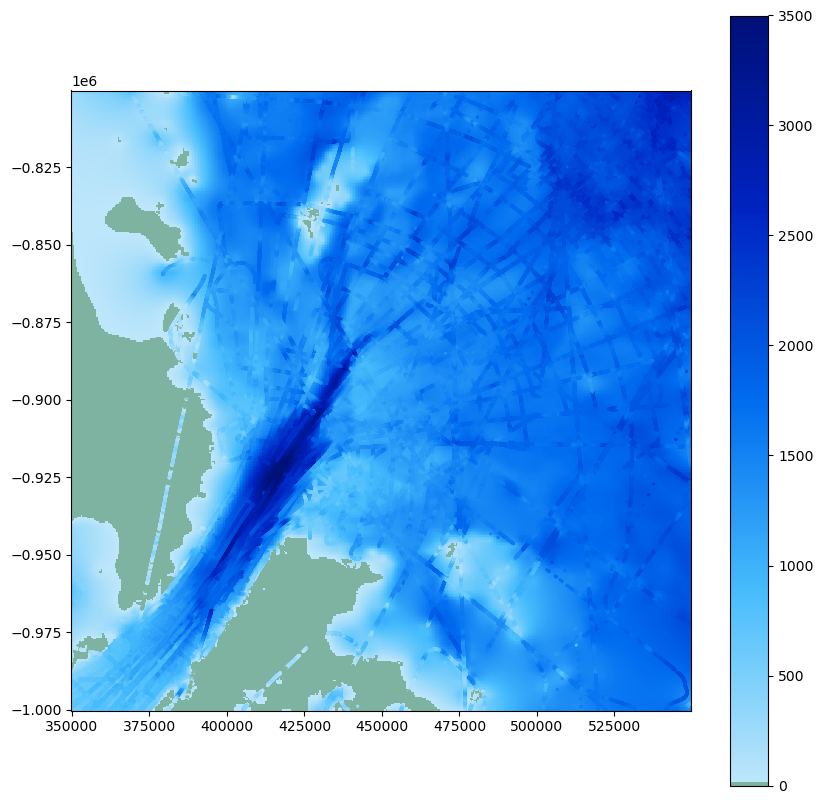

In [26]:
XX, YY = np.meshgrid(byrd_bedmachine.x, byrd_bedmachine.y)

fig, ax = plt.subplots(figsize = (10, 10))

# Plot bed topography mesh
ax.pcolormesh(XX, YY, byrd_bedmachine.thickness_ellipsoid_true, cmap = icethickness_cmap, vmin = 0, vmax = 3500)

# Plot data points
ax.scatter(byrd_bedmap_points_cleaned["x"], byrd_bedmap_points_cleaned["y"], 
           c = byrd_bedmap_points_cleaned["t"], 
           s = 2,
           cmap = icethickness_cmap, vmin = 0, vmax = 3500)

fig.colorbar(mappable = ax.collections[0], ax = ax)
ax.set_aspect('equal')

## Repeat for bed topo

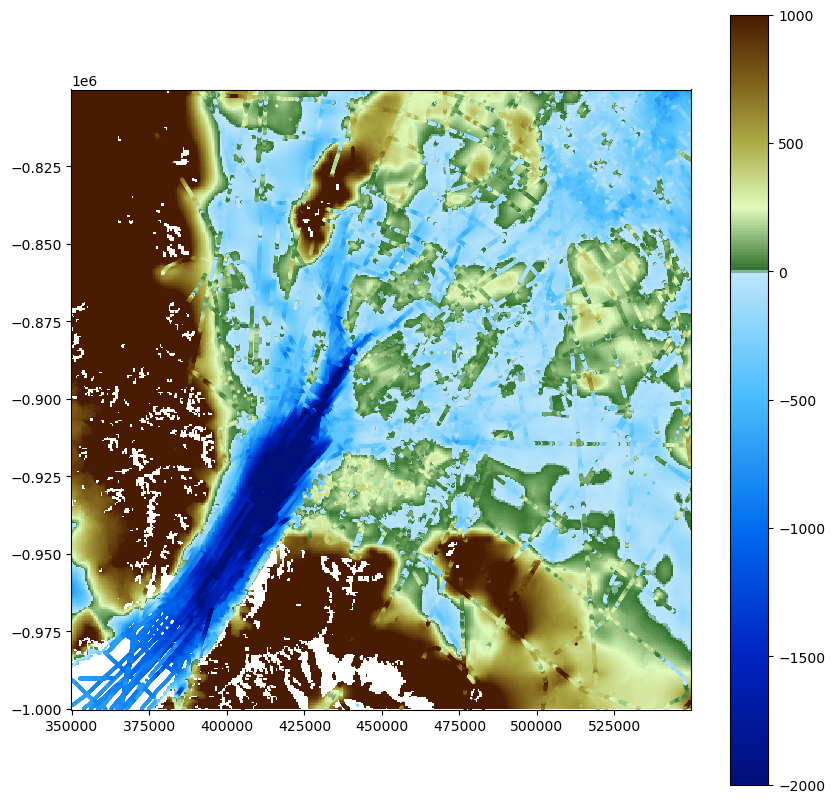

In [27]:
XX, YY = np.meshgrid(byrd_bedmachine.x, byrd_bedmachine.y)

fig, ax = plt.subplots(figsize = (10, 10))

# Plot bed topography mesh
ax.pcolormesh(XX, YY, byrd_bedmachine.bed_ellipsoid, cmap = bedmachine_cmap, vmin = -2000, vmax = 1000)

# Plot data points
ax.scatter(byrd_bedmap_points_cleaned["x"], byrd_bedmap_points_cleaned["y"], 
           c = byrd_bedmap_points_cleaned["b"], 
           s = 2,
           cmap = bedmachine_cmap, vmin = -2000, vmax = 1000)

fig.colorbar(mappable = ax.collections[0], ax = ax)
ax.set_aspect('equal')

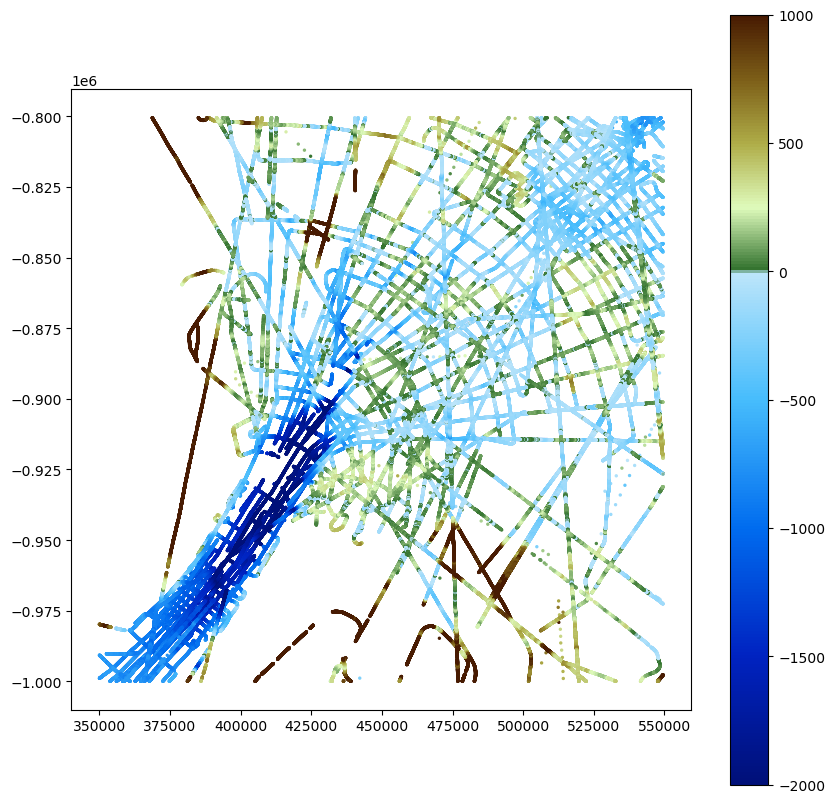

In [29]:
XX, YY = np.meshgrid(byrd_bedmachine.x, byrd_bedmachine.y)

fig, ax = plt.subplots(figsize = (10, 10))

ax.scatter(byrd_bedmap_points_cleaned["x"], byrd_bedmap_points_cleaned["y"], 
           c = byrd_bedmap_points_cleaned["b"], 
           s = 2, 
           cmap = bedmachine_cmap, vmin = -2000, vmax = 1000)

fig.colorbar(mappable = ax.collections[0], ax = ax)
ax.set_aspect('equal')

# Export cleaned data

In [42]:
byrd_bedmap_points_cleaned.to_csv('/home/kim/ice_thickness/data/byrd_bedmap_points_clean.csv')

# White overlay just to show where we have data

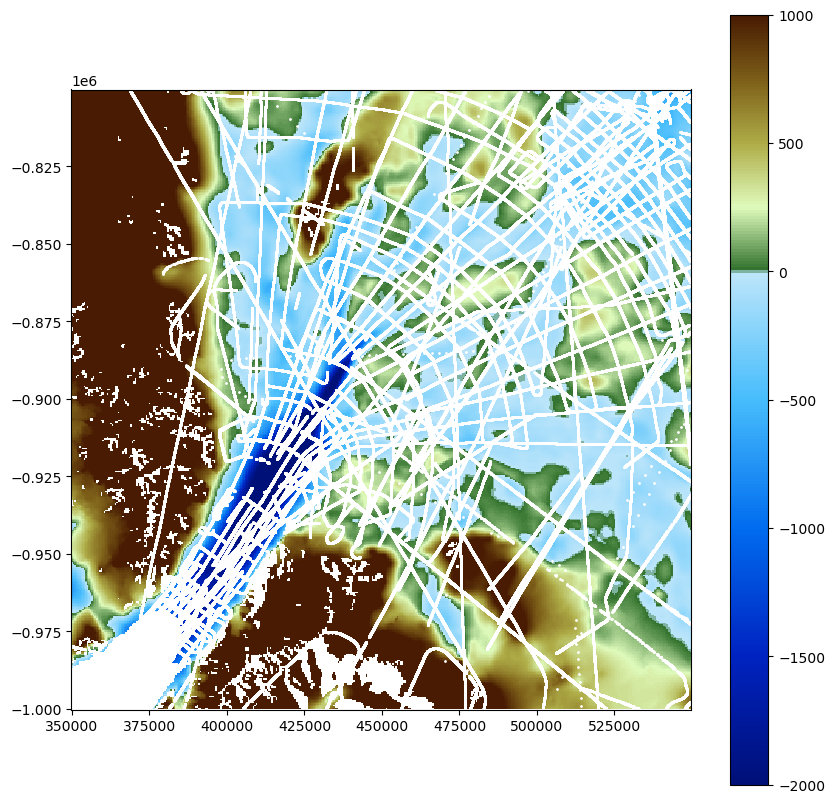

In [31]:
XX, YY = np.meshgrid(byrd_bedmachine.x, byrd_bedmachine.y)

fig, ax = plt.subplots(figsize = (10, 10))

# Plot bed topography mesh
ax.pcolormesh(XX, YY, byrd_bedmachine.bed_ellipsoid, cmap = bedmachine_cmap, vmin = -2000, vmax = 1000)

# Plot data points
ax.scatter(byrd_bedmap_points_cleaned["x"], byrd_bedmap_points_cleaned["y"], 
           c = "white",
           s = 1)

fig.colorbar(mappable = ax.collections[0], ax = ax)
ax.set_aspect('equal')

# Subset smaller area to see pixels

In [32]:
# Edge of ice stream
x_min = 375000 + 500
x_max = 400000

y_min = -900000 + 500
y_max = -975000

In [33]:
# Island (interesting)
x_min = 420000 + 500
x_max = 445000

y_min = -850000 + 500
y_max = -825000

In [34]:
# Narrow stream
x_min = 420000 + 500
x_max = 445000

y_min = -900000 + 500
y_max = -875000

In [35]:
byrd_bedmap_points_zoom = byrd_bedmap_points_cleaned[
    (byrd_bedmap_points_cleaned["x"] > x_min) & 
    (byrd_bedmap_points_cleaned["x"] < x_max) & 
    (byrd_bedmap_points_cleaned["y"] > y_min) & 
    (byrd_bedmap_points_cleaned["y"] < y_max)]

byrd_bedmap_points_zoom

,Unnamed: 0,lon,lat,x,y,s,t,b,b_inferred,source
67,67,153.523000,-80.910000,441221.317948,-885843.398034,1165.00,1003.00,162.00,False,BEDMAP1_1966-2000_AIR_BM1.csv
68,68,153.402600,-80.897800,443678.914546,-886106.750572,1191.00,905.00,286.00,False,BEDMAP1_1966-2000_AIR_BM1.csv
134,134,153.177400,-80.978390,443183.389487,-876494.750747,1332.00,1033.00,299.00,False,BEDMAP1_1966-2000_AIR_BM1.csv
135,135,153.304700,-80.964800,441902.216172,-878804.339821,1288.00,954.00,334.00,False,BEDMAP1_1966-2000_AIR_BM1.csv
176,176,154.497200,-80.982100,422703.079329,-886103.991044,1068.00,1247.00,-179.00,False,BEDMAP1_1966-2000_AIR_BM1.csv
...,...,...,...,...,...,...,...,...,...,...
443697,443697,153.687119,-80.881028,440085.944673,-889942.488152,992.18,1104.19,-112.01,False,UTIG_2010_ICECAP_AIR_BM3.csv
443698,443698,153.687639,-80.881209,440069.097306,-889928.746111,922.28,1083.80,-161.52,False,UTIG_2010_ICECAP_AIR_BM3.csv
443699,443699,153.688180,-80.881397,440051.584873,-889914.479200,990.69,1130.84,-140.15,False,UTIG_2010_ICECAP_AIR_BM3.csv
443700,443700,153.688699,-80.881578,440034.753625,-889900.729014,961.16,1104.61,-143.45,False,UTIG_2010_ICECAP_AIR_BM3.csv


In [36]:
byrd_bedmachine_zoom = byrd_bedmachine.sel(y = slice(y_max, y_min),
                                        x = slice(x_min, x_max))

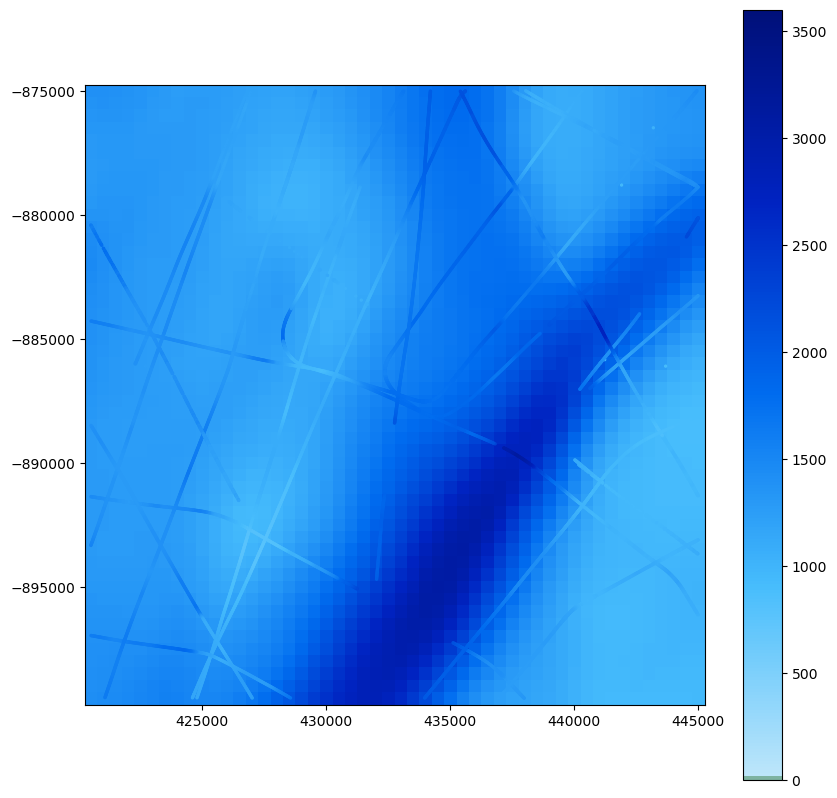

In [37]:
XX, YY = np.meshgrid(byrd_bedmachine_zoom.x, byrd_bedmachine_zoom.y)

fig, ax = plt.subplots(figsize = (10, 10))

# Plot bed topography mesh
ax.pcolormesh(XX, YY, byrd_bedmachine_zoom.thickness_ellipsoid_true, cmap = icethickness_cmap, vmin = 0, vmax = 3600)

# Plot data points
ax.scatter(byrd_bedmap_points_zoom["x"], byrd_bedmap_points_zoom["y"], 
           c = byrd_bedmap_points_zoom["t"], 
           s = 2,
           cmap = icethickness_cmap, vmin = 0, vmax = 3620)

fig.colorbar(mappable = ax.collections[0], ax = ax)
ax.set_aspect('equal')

# Check difference of correction

In [39]:
byrd_bedmachine_zoom.thickness_ellipsoid_true

<xarray.DataArray 'thickness_ellipsoid_true' (y: 50, x: 50)>
array([[1398.1183 , 1399.6023 , 1388.9546 , ..., 1342.0808 , 1359.4343 ,
        1374.3337 ],
       [1374.4987 , 1379.3741 , 1372.4358 , ..., 1335.1901 , 1353.4846 ,
        1367.7535 ],
       [1348.1189 , 1356.2356 , 1352.6478 , ..., 1330.5946 , 1347.5516 ,
        1360.5369 ],
       ...,
       [1412.5775 , 1423.0886 , 1431.967  , ...,  962.6774 ,  955.9681 ,
         954.6067 ],
       [1416.1853 , 1431.6295 , 1444.5359 , ...,  945.614  ,  947.1858 ,
         949.4019 ],
       [1423.7843 , 1439.6335 , 1457.6809 , ...,  930.5833 ,  939.47723,
         947.8429 ]], dtype=float32)
Coordinates:
  * x        (x) int32 420500 421000 421500 422000 ... 444000 444500 445000
  * y        (y) int32 -875000 -875500 -876000 ... -898500 -899000 -899500

In [ ]:
byrd_bedmachine_zoom.thickness